In [2]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()
from utils.func import center
from quantstats.stats import sharpe
import matplotlib.pyplot as plt

In [3]:
market_data = pd.read_parquet('data/US/mkt_data.pq')
balance_sheet = pd.read_parquet('data/US/balance_sheets.pq')
GICS = pd.read_parquet('data/US/GICS.pq')
P = pd.read_parquet('data/US/universe_table.pq')
R = market_data['close'].unstack().reindex_like(P).pct_change()
market_data.head()

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2008-01-02,A,2008-01-02,36.6587,36.7886,36.1089,36.2888,23.4977,1858900,NaN
2008-01-03,A,2008-01-03,36.2888,36.3388,35.8589,35.9289,23.2647,1995302,NaN
2008-01-04,A,2008-01-04,35.5690,35.8389,34.7093,34.7593,22.5073,3533080,NaN
2008-01-07,A,2008-01-07,35.3291,35.8689,35.0392,35.3291,22.8763,3505732,NaN
2008-01-08,A,2008-01-08,35.3491,35.7390,35.1392,35.2791,22.8439,4063445,NaN


In [5]:
earnings = pd.read_parquet('data/US/earnings.pq')
earnings['Date'] = pd.to_datetime(earnings['reportDate'])
earnings = earnings.droplevel(0).set_index('Date',append=True)
earnings = earnings.reorder_levels(['Date','Ticker'])
earnings = earnings[~earnings.index.duplicated(keep='first')]
earnings = earnings[earnings['epsActual'].notna()]
earnings.head()

,,reportDate,date,beforeAfterMarket,currency,epsActual,epsEstimate,epsDifference,surprisePercent
Date,Ticker,,,,,,,,
2000-02-17,A,2000-02-17,2000-01-31,None,USD,0.30,0.22,0.08,36.3636
2000-05-16,A,2000-05-16,2000-04-30,None,USD,0.35,0.32,0.03,9.3750
2000-08-17,A,2000-08-17,2000-07-31,None,USD,0.39,0.20,0.19,95.0000
2000-11-20,A,2000-11-20,2000-10-31,None,USD,0.73,0.54,0.19,35.1852
2001-02-20,A,2001-02-20,2001-01-31,None,USD,0.51,0.45,0.06,13.3333


In [6]:
eps_actual = earnings['epsActual'].unstack().reindex_like(P).ffill().astype(float)
eps_estimate = earnings['epsEstimate'].unstack().reindex_like(P).ffill().astype(float)
eps_suprise  = (eps_actual - eps_estimate).reindex_like(P).ffill()[P]

C:\Users\marti\AppData\Local\Temp\ipykernel_13344\312141657.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  signal = signal[P].rolling(252,min_periods=20).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
C:\Users\marti\AppData\Local\Temp\ipykernel_13344\312141657.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)


Sharpe                2.2
Daily turnover (%)    8.3
biais (bp)            1.9
dtype: float64

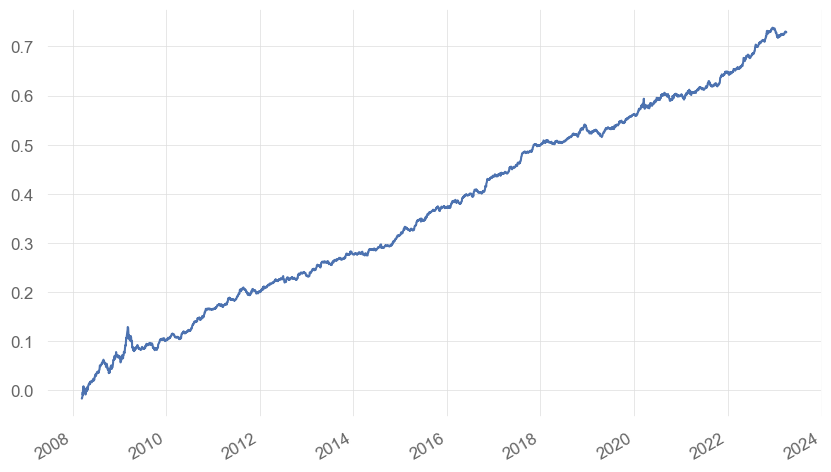

In [14]:
signal = eps_suprise[P]
signal = signal[P].rolling(252,min_periods=20).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
signal = signal[P].rank(axis=1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

signal[signal.abs()<0.5] = None
signal = signal[P].groupby(GICS['gicind'],axis=1).apply(center)
signal = signal[P].div(signal[P].abs().sum(1),0)

PNL = (signal[P].shift()*R).sum(1).replace({0:np.nan}).dropna()
sr = sharpe(PNL)
turnover = signal.fillna(0).diff().abs().sum(1).mean()
PNL.cumsum().plot()
pd.Series({'Sharpe':sr,'Daily turnover (%)':turnover *100,'biais (bp)':PNL.mean()*1e4}).round(1)

<Axes: >

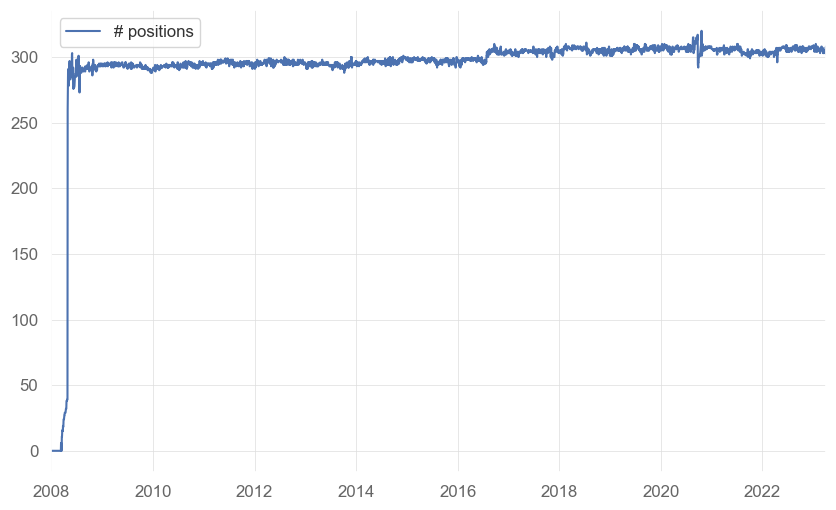

In [15]:
signal.count(1).plot(label ='# positions',legend=True)

<Axes: >

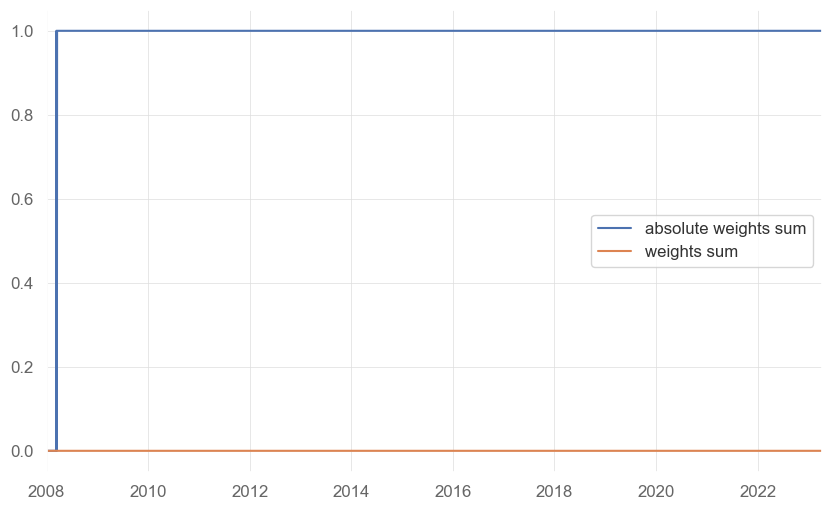

In [16]:
signal.abs().sum(1).plot(label = 'absolute weights sum',legend=True)
signal.sum(1).plot(label='weights sum',legend=True)